## Trabalho Prático nº4 - Grupo 8

### Dilithium

No âmbito do último trabalho prático, foi proposta a implementação
da técnica **Dilithium**, na forma de um protótipo.
Este é um **esquema da assinatura digital** presente no concurso 
*NIST PQC* que utiliza o esquema *LWE* básico (com ponto de partida).

Tal como recomendado no enunciado, seguir-se-á o *paper* __[Dilithium](https://www.dropbox.com/sh/5wxso1sx6gnnym0/AACF7Kvmrkpqmv9oCfL4jq6na/Dilithium/dilithium/Supporting_Documentation/dilithium_nist.pdf?dl=0)__.

Este *paper* descreve as diferenças entre a primeira e segunda ronda (*round 1*, *round 2*) submetidas para o algoritmo *Dilithium* e a corrente versão atualizada (*round 3*);
podendo agora o esquema ser aleatório, para além de determinístico.

O nível de segurança, do algoritmo *Dilithium*, tem por base a dificuldade
em encontrar **pequenos vetores em *lattices***.
É projetado para ser:
- Simples de implementar (com segurança);
- Conservador com os parâmetros;
- Um esquema que utiliza uma chave pública e assinaturas de tamanho menor (melhor *performance*);
- Modular (fácil de variar os seus parâmetros de segurança).

O *design* do esquema é baseado na abordagem *Fiat-Shamir with Aborts*, sendo
uma versão simplificada (e menos eficiente) a seguinte:

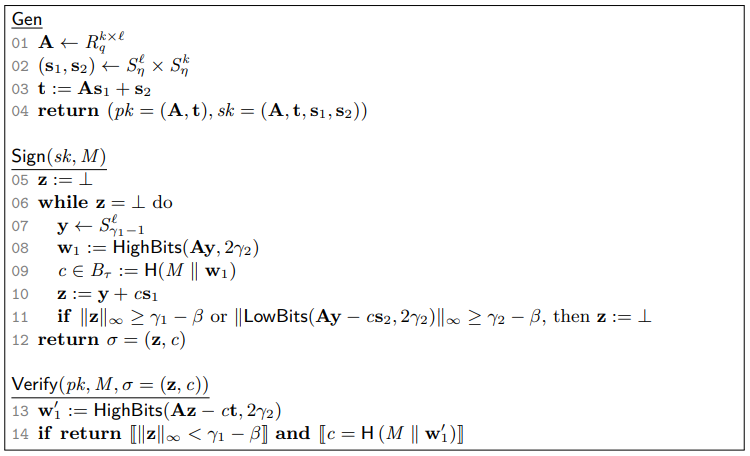

Neste caso vê-se os algoritmos para **geração de chaves**, **assinatura** e **verificação**. 

#### Key Generation

No processo de geração de chaves, tem-se:

1. Geração de uma matriz k x l, **A** (cada um dos seus valores é um **polinómio** no anel Rq = Zq{X}/(Xn + 1)).
2. Criação das *samples* vetoriais **s1** e **s2** aleatórias, para a **chave privada** (cada coeficiente destes vetores é um elemento de Rq, com coeficientes de tamanho n, no máximo).
3. A segunda parte da chave pública é computada como t = As1 + s2.

Adicionalmente, supõe-se que todas as operações algébricas, aqui, são feitas sobre o anel polinomial, Rq.

#### Signing Procedure

O método ```Sign``` será o responsável por criar a assinatura final,
com base na chave privada (sobre uma dada menagem).

Relativamente a este, tem-se:

1. O procedimento de assinatura começa com a geração de um vetor máscara de polinômios **y** com coeficientes menores que *γ1*, onde *γ1* é escolhido estrategicamente para equilibrar segurança e resistência contra falsificação (parametrização definida no documento); de forma que a assinatura não revele a chave secreta e não seja facilmente falsificada.

2. Calcular o produto Ay, onde A é a matriz gerada na etapa ExpandA e y é o vetor máscara. Extrair os bits de ordem alta dos coeficientes em Ay para obter w1. Cada coeficiente w em Ay pode ser expresso como **w = w1 · 2γ2 + w0**, onde **|w0| ≤ γ2**. w1 é um vetor composto por todos os valores w1.

3. Criar um desafio *c* aplicando uma função de *hash* à mensagem e a *w1*. O *output c* é um polinômio em Rq com exatamente τ ±1's e o restante 0's. A distribuição de *c* é escolhida de forma a que ela tenha uma norma pequena e tenha origem num domínio de tamanho log2(256τ + τ), com o objetivo de estar entre 128 e 256.

4. Calcular a assinatura potencial como **z = y + cs1**, onde s1 é um vetor secreto.

5. Realizar amostragem por rejeição para garantir que a assinatura não revele a chave secreta. Definir o parâmetro β como o coeficiente máximo possível de csi. Se algum coeficiente de z for maior que **γ1 − β** ou se algum coeficiente dos bits de ordem baixa de **Az − ct** (onde t é um termo de ruído) for maior que **γ2 − β**, o procedimento é **reiniciado**. A primeira condição garante a segurança, enquanto a segunda condição garante a correção e a segurança.

6. Repetir o procedimento de assinatura (passos 1-5) até que as condições para amostragem por rejeição sejam satisfeitas. Os parâmetros são ajustados de forma que o número esperado de repetições não seja muito alto.

O objetivo da amostragem por rejeição é evitar que a assinatura dependa da chave secreta e garantir que a assinatura resultante seja segura.
Ao repetir o procedimento até que as condições de rejeição sejam atendidas, o assinante pode produzir uma assinatura válida sem revelar informações sensíveis.

#### Verification

Por fim, o ```Verify``` será responsável por avaliar a correção da
assinatura previamente gerada (e se esta encontra-se válida para uma dada mensagem);
recebe, para isso, a chave pública.

O verificador primeiro calcula w1 como os bits de ordem alta de Az - ct e, em seguida, aceita a assinatura se todos os coeficientes de z forem menores que γ1 - β e se c for o hash da mensagem e de w1.


In [1]:
#imports
import os, sys
from cryptography.hazmat.primitives import hashes
from pickle import load, dumps
import random as rn

### Classe __'Dilithium'__

Numa versão mais atualizada, a corrente (atual), do *Dilithium*,
apresenta-se numa classe (do mesmo nome), uma implementação do esquema de assinatura.

Utiliza-se a versão mais atualizada, uma vez que o *template* apresentado em cima é bastante 
**inefeciente**.
O maior problema encontra-se na **representação da chave pública**, numa matriz **A**^*k x l* (sendo que esta pode ser penosa, em termos de tamanho).
A solução, como iremos ver, parte na utilização de uma *seed p*, utilizando *SHAKE-128* 
para a criação da matriz **A**. A chave pública será (ρ, t) e o seu tamanho será dominado por t.

Para tal seguiu-se os algoritmos para **geração de chaves**, **assinatura** e **verificação** presentes na **página 19** do *paper* anteriormente mencionado.
Estes algoritmos, formalmente, encontram-se apresentados como:

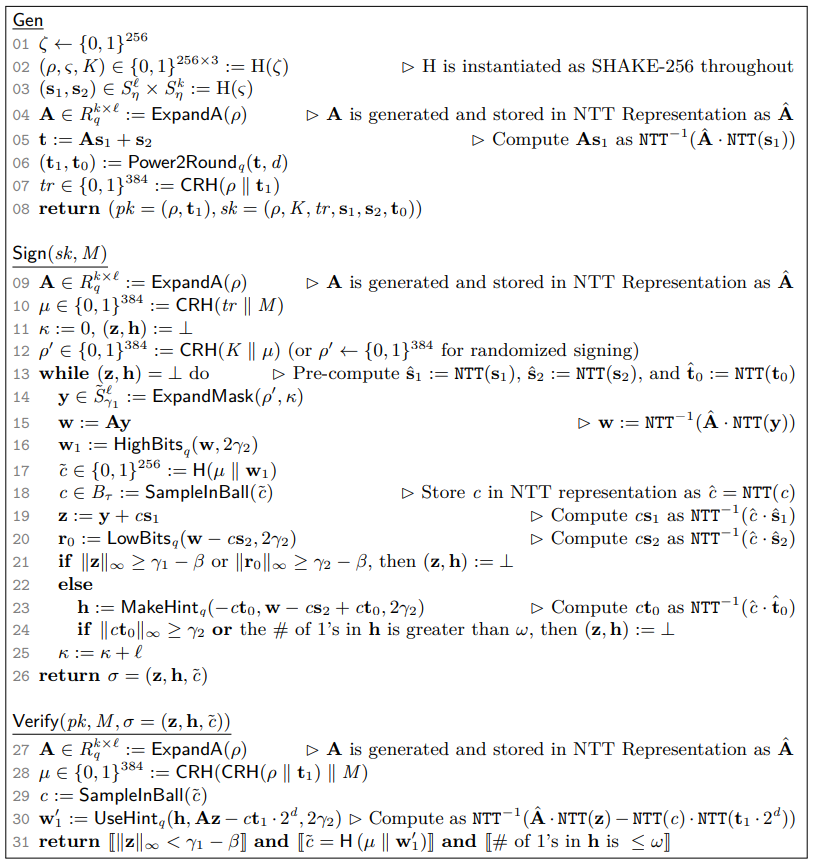

Como se tinha mencionado previamente, o algoritmo sofreu alterações e, no documento,
é apresentado de forma iterativa estas.
Sendo assim, os algoritmos atuais para a implementação do esquema de assinatura *Dilithium* são:

#### Key generation

Tal como mencionado anteriormente, será necessária a criação de chaves públicas-privadas
para a criação e verificação das assinaturas.
Para tal seguir-se-á o algoritmo para a função ```Gen```, como apresentada no *paper*.

1. Cria-se um valor aleatório de 32 bytes, *ζ*, para gerar as variáveis *ρ, ς, K* com o método ```H3```.
2. Cria-se as samples *s1* e *s2* (vetores), usando a variável ς a partir do método ```createSamplesH```.
3. Cria-se a matriz A ∈ Rq, a partir de ρ e o método ```ExpandA```.
4. O vetor *t* é calculado através da expressão *t := A*s1 + s2*, a utilizar no método ```Power2Round``` para partir *bit wise* os elementos do anel Rq (o *output* é o par (t1,t0)).
5. A variável *t1* e *ρ* será utilizada na função de *hash* *CRH* para gerar *tr*.
6. A chave pública *pk = (p, t1)* e a chave privada *sk=(p,k,tr,s1,s2,t0)*. 

...A matriz A tem por base a criação de um inteiro 2 bytes em formato *little endian* (*n * i + j, i ∈ {o..k}* e *j ∈ {0..l}*).
Vão ser utilizados no método ```hash128```, para depois gerar um *integer* a partir do método ```generate_Int```. 
Os 3 bytes (resultantes desta função) serão interpretados como um inteiro em formato *little endian*.
Todos coeficentes dos polinómios da matriz *A* serão assim calculados.

#### Signing procedure

O método ```Sign``` é responsável por assinar uma mensagem para envio, retornando a assinatura gerada; 
recorrendo à chave privada *sk* e a mensagem em *bytes M*. 

1. O método inicia-se com a geração da matriz *A* (```ExpandA``` e a variável *ρ*). 
2. Gera-se a variável *μ* usando a função *CRH* com as variáveis *tr* e *M*
3. Do mesmo modo, gera-se a variável *ρ'*, neste caso, com as variáveis *K* e *μ*.

São geradas as variáveis *z* e *h*, dentro de um ciclo, e serão atualizadas até satisfazerem a condição de saída: *||z||∞ ≥ γ1 − β ou ||r0||∞ ≥ γ2 − β* e o número de 1's em *h ≤ ω*. 

5. Começa-se por criar a variável *y* recorrendo ao método ```ExpandMask``` (com as variáveis *ρ'* e *k*).

6. Gera-se o vetor *w* (*w = A * y*). Com base neste, e no método ```HighBits``` (extração dos *high-order bits* do ```Decompose```), calcula-se *w1*; que terá uso no *sampling in a ball*.

7. Antes de realizar o *sampling in a ball* (que resulta na variável *c*), tem-se de calcular a variável *c2*. Esta será a partir do uso do método ```H1``` em conjunto com μ, como *seed*.

8. *z* é o resultado de *z = y + c * s1*.

9. Calcula-se *r0* com o método ```LowBits``` (extração os *low-order bits* do```Decompose```), tal como descrito no *paper*. 

10. A variável *h* é o resultado de ```MakeHint``` (dica a ser usada por ```UseHint```). 

11. Caso a condição não for satisfeita -> *k = k + l*. 

12. Caso a condição seja satisfeita, a assinatura é dada por *α=(z,h,c2)*.

A geração do vetor y é realizada da seguinte maneira:

1. Primeiro, é gerado um número inteiro de 2 bytes em formato *little endian* a partir da expressão *k+i*, onde *i* pertence ao conjunto *{0...l}*.
2. Esses 2 *bytes* são combinados com a variável *ρ'* e passados para a função de hash ```hash256```.
3. O output da função ```hash256``` é, então, utilizado como entrada para a função ```generate_Int_Mask```.
4. A função generate_Int_ask processa os primeiros 3 bytes do output recebido. Dependendo se γ1 é igual a 2^17 ou 2^19, ela transforma os dois primeiros bytes em 2 bits ou os 4 bits do terceiro byte.
5. Os 3 bytes resultantes são interpretados como um número inteiro em formato little endian, gerando assim os coeficientes dos polinômios que compõem o vetor y.
Dessa forma, o vetor *y* é gerado com base nos passos descritos acima.

Por outro lado, a geração do vetor *c* é feita da seguinte forma:

1. Utiliza-se a função ```hash256``` para gerar uma *hash* de *n bytes* a partir da variável recebida como parâmetro.
2. Em seguida, são gerados os *sign bits* utilizando a função ```generate_Bits```. 
3. Essa função usa os primeiros *8 bytes*, onde os primeiros *r bits* (peso de *c*) correspondem aos *sign bits*.
4. Cada *byte* do *output* de *hash256* corresponde a um número inteiro em formato *little endian*, que será gerado pela função ```generate_Int_J```.
5. Após obter o valor inteiro *j* e os *sign bits s*, aplica-se o algoritmo *"sample in ball"* conforme descrito na página 10 da documentação.
O resultado final é o vetor *c* gerado.

#### Verification

O método ```Verify``` tem como objetivo verificar a autenticidade da assinatura recebida como parâmetro quando associada à mensagem *M*, utilizando a chave pública.

Para verificar a autenticidade da assinatura, verifica-se a seguinte condição: *||z||∞ < γ1 − β e c' = H(μ || w') e o número de 1's em h é ≤ ω*.

Começa-se por calcular a matriz *A* (```ExpandA``` e a variável *ρ*). 
Calcula-se a variável *μ* usando o método ```CRH``` sobre aplicada a *CRH(ρ + t1) + M*.

*c* é o resultado da utilização do método ```SampleInBall``` e a variável *c2*. 
Calcula-se a dica com ```UseHint``` para determinar *w1 = UseHint(h, A * z − c * t1 * 2^d, 2 * γ2)*. 

In [2]:
class Dilithium:
    
    ##############################################################################################
    ## ---------------------- Parametrização Dilithium - nível 5+ (NIST) ---------------------- ##
    ##############################################################################################
    
    def __init__(self):
        self.q = 8380417 
        self.d = 13
        self.c = 60
        self.n = 256
        self.y1 = 2**19 
        self.y2 = (self.q - 1)//32
        self.k = 9
        self.l = 8
        self.nn = 2
        self.b = 120
        self.w = 85
        
        Z.<x> = ZZ[]
        R.<x> = QuotientRing(Z,Z.ideal(x^self.n+1))
        
        self.R = R
        
        Zq.<x> = GF(self.q)[]
        fi = x^self.n + 1
        Rq.<x> = QuotientRing(Zq,Zq.ideal(fi))

        self.Rq = Rq
    
    ##############################################################################################
    ## ---------------------------------- Funções Principais ---------------------------------- ##
    ##############################################################################################
    
    # Função que cria um par de chaves privada-pública (pk, sk)
    def Gen(self):
        
        # ζ ← {0, 1}^256 (256 bits = 32 bytes)
        z = os.urandom(32)
        
        #(ρ, ς, K) ∈ {0, 1}^256×3 := H(ζ)
        (ro, c, K) = self.H3(z)
        
        #(s1,s2) ∈ Sη^l × Sη^k := H(ς)
        (s1,s2) = self.createSamplesH(c)
        
        #A ∈ Rq^k×l := ExpandA(ρ)
        A = self.ExpandA(ro)
        
        #t := A*s1 + s2
        t = A * s1 + s2
        
        #(t1,t0) := Power2Round(t, d)
        (t1, t0) = self.Power2Round(t, self.d)
        
        #tr ∈ {0, 1}^384 := CRH(ρ || t1)
        pt1 = ro + dumps(t1)
        tr = self.CRH(pt1)
        
        #return (pk = (ρ, t1), sk = (ρ, K, tr, s1, s2, t0))
        #return pk, sk
        return (ro, t1),(ro, K, tr, s1, s2, t0)
    
    #Implementação do método para assinar uma dada mensagem, usando a chave privada sk
    def Sign(self, sk, M):
        
        (ro, K, tr, s1, s2, t0) = sk
        
        #A ∈ Rq^k×l := ExpandA(ρ)
        A = self.ExpandA(ro)
        
        #μ ∈ {0, 1}^384:= CRH(tr || M)
        u = self.CRH(tr + M)
        
        #κ := 0
        k = 0
        
        #(z, h) := ⊥
        (z, h) = (None, None)
        
        #ρ' ∈ {0,1}^384 := CRH(K || μ)
        ro2 = self.CRH(K + u)
        
        # while (z, h) = ⊥ do
        while z == None or h == None:
            
            #y ∈ Sγ^l := ExpandMask(ρ', κ)
            y = self.ExpandMask(ro2, k)
            
            #w := Ay
            w = A * y
        
            #w1 := HighBits(w, 2*γ2 )
            w1 = self.HighBits(w, 2*self.y2)
            
            #c' ∈ {0,1}^256 := H(μ || w1)
            c2 = self.H1(u + dumps(w1), 32)
            
            #c ∈ Bτ := SampleInBall(c')
            c = self.SampleInBall(c2)
            
            #z := y + c * s1
            z = y + c * s1
            
            #r0 := LowBits(w − c*s2 , 2*γ2)
            r0 = self.LowBits(w - c * s2 , 2 * self.y2)
            
            #if ||z||∞ ≥ γ1 − β or ||r0||∞ ≥ γ2 − β
            if self.normInf(z) >= (self.y1 - self.b) and self.normInf(r0) >= (self.y2 - self.b):
                
                #then (z, h) := ⊥
                (z, h) = (None, None)
            
            else:
                
                #h := MakeHint(−c*t0 , w − c*s2 + c*t0 , 2*γ2)
                h = self.MakeHint(-c*t0 , w - c*s2 + c*t0 , 2 * self.y2)
                
                #||c*t0||∞ ≥ γ2 or the # of 1’s in h is greater than ω
                if self.normInf(c * t0) >= self.y2 or h.count(True) > self.w:
                    
                    #(z, h) := ⊥
                    (z, h) = (None, None)
            
            #κ := κ + l
            k = k + self.l
        
        # return σ = (z, h, ˜c)
        return (z,h,c2)
    
    #Implementação do método para verificar uma assinatura, a partir da chave pública
    def Verify(self, pk, M, sig):
        
        (ro, t1) = pk
        (z,h,c2) = sig
        
        #A ∈ Rq^k×l := ExpandA(ρ)
        A = self.ExpandA(ro)
        
        #μ ∈ {0, 1}^384 := CRH(CRH(ρ + t1) + M )
        y = self.CRH(self.CRH(ro + dumps(t1)) + M)
        
        #c := SampleInBall(c')
        c = self.SampleInBall(c2)
        
        #w' = UseHint(h, A*z − c*t1 * 2^d , 2*γ2)
        w1 = self.UseHint(h, (self.Rq2R(A) * z) - (c * t1 * 2^self.d), 2 * self.y2)
        
        #return ||z||∞ < γ1 − β and c' = H(μ || w') and J# of 1’s in h is ≤ ω
        return self.normInf(z) < (self.y1-self.b) and c2 == self.H1(y + dumps(w1), 32) and h.count(True) <= self.w
    
    ###############################################################################################
    ## ----------------------------------- Funções Auxiliares ---------------------------------- ##
    ###############################################################################################
    
    ## ---------------- Método H3 ---------------- ##
    
    #Implementação do método H - criação do triplo (ρ, ς, K)
    def H3(self, C):
        
        digest = hashes.Hash(hashes.SHAKE256(int(96))) 
        digest.update(C)
        buffer = digest.finalize() 
        
        # 96 bytes (256bits x 3)
        return (buffer[:32], buffer[32:64], buffer[64:])
    
    ## ---------------- Método H1 ---------------- ##
    
    #Implementação do método H - um único output
    def H1(self, m, length):
        
        digest = hashes.Hash(hashes.SHAKE256(int(length)))
        digest.update(m)
        h = digest.finalize()
    
        return h
    
    ## ---------------- Método createSamplesH ---------------- ##
    
    #Implementação do mod+- (Modular Reductions)
    def modPMAux(self,r,a):
        
        if a%2 == 0:
            lim = a/2
        else:
            lim = (a-1)/2
            
        mod = r % a
        
        if mod > lim:
            mod -= a
            
        return mod
     
    # Geração de s1 e s2 (samples), com base numa seed c
    def createSamplesH(self, c):
        
        h = self.H1(c, self.l*self.n + self.k*self.n)
        ind = 0
        s1 = []
        
        for i in range(self.l):
            p = []          
            for j in range(self.n):
                num = h[ind]
                p.append(self.modPMAux(num,self.nn))
                ind += 1
                
            s1.append(self.R(p))
            res_s1 = vector(s1)
            
        s2 = []
        
        for i in range(self.k):
            p = []     
            for j in range(self.n):
                num = h[ind]
                p.append(self.modPMAux(num,self.nn))
                ind += 1
                
            s2.append(self.R(p))            
            res_s2 = vector(s2)
        
        return (res_s1, res_s2)
    
    ## ---------------- Método ExpandA ---------------- ## 
    
    # Método Hash - Utiliza SHAKE128
    def hash128(self, seed):

        digest = hashes.Hash(hashes.SHAKE128(int(self.n-1)))
        digest.update(seed)

        return digest.finalize()

    # Geração do integer como especificado
    #(This is done by setting the highest bit of every third byte to zero and interpreting blocks of 
    #3 consecutive bytes in little endian byte order. So for example the three bytes b0, b1 and b2 
    #are used to get the integer 0 ≤ b2· 2^16 + b1 · 2^8 + b0 ≤ 2^23 − 1 where b2 is the logical 
    #AND of b2 and 2^128 − 1.)
    def generate_Int(self, offset, seed):

        if(len(offset)<3):
            offset = seed

        thr = bytearray(offset[:3])
        thr[2]  &= 0x7f
        thr = bytes(thr)

        res = int.from_bytes(thr, "little")

        return res, offset[3:]    
    
    # Mapeia uma seed uniforme (ρ) para uma matriz A (pertencente a Rq^(kxl)) em NTT
    # A matriz será utilizada para multiplicações nos algoritmos do esquema
    # O output será  A ∈ Zq^256, ou seja, a representação de A no domínio NTT
    def ExpandA(self,ro):
    
        A = []
        
        for i in range(self.k):
            row = []
            for j in range(self.l):
                coefs = []
                intTwoBytes = int(self.n*i + j).to_bytes(2, "little")
                hash_res = self.hash128(ro + intTwoBytes)
                seed = hash_res
                
                for cof in range(self.n): 
                    number, hash_res = self.generate_Int(hash_res, seed)
                
                    coefs.append(number)
                row.append(self.Rq(coefs))
            A.append(row)
            
        res = Matrix(A)
        
        return res

    ## ---------------- Método Power2Round ---------------- ##
    
    # Implementação do mod+- num vetor
    def modPM(self, v,a):
        
        r = []
        
        for i in v:
            iAux = []
            for j in i:
                iAux.append(self.modPMAux(j,a))
                
            r.append(self.R(iAux))
            
        res = vector(r)
        
        return res

    # Implementação do mod+ num vetor
    def modP(self, v,a):
        
        r = []
        
        for i in v:
            iAux = []
            for j in i:
                iAux.append(mod(j,a))
                
            r.append(self.R(iAux))
            
        res = vector(r)
        
        return res
    
    # Método para  realizar o arredondamento de potência de 2 durante a 
    # geração de chaves e a assinatura de mensagens. 
    # Ela ajuda a garantir a segurança do esquema e a resistência a ataques.
    def Power2Round(self,r,d):
        
        #r := r mod+ q
        r = self.modP(r,self.q)
        
        #r0 := r mod± 2^d
        r0 = self.modPM(r,2^d)
        
        # return ((r − r0)/2^d, r0)
        return ((r - r0)/2^d, r0)
    
    ## ---------------- Método Collision Resistant hashing ---------------- ##
    
    #Implementação do Collision resistant hashing - SHAKE-256
    def CRH(self,seed):
        
        digest = hashes.Hash(hashes.SHAKE256(int(48)))
        digest.update(seed)
        
        return digest.finalize()
    
    ## ---------------- Método ExpandMask ---------------- ##
        
    # Método Hash - SHAKE-256
    def hash256(self,seed):

        digest = hashes.Hash(hashes.SHAKE256(int(self.n-1)))
        digest.update(seed)

        return digest.finalize()

    # Método que gera o inteiro segundo regras apresentadas
    def generate_Int_Mask(self, offset, seed):

        if(len(offset)<3):
            offset = seed

        thr = bytearray(offset[:3])

        if self.y1 == 2**17:
            thr[2]  &= 0x3
        else:
            thr[2]  &= 0xf

        thr = bytes(thr)
        res = int.from_bytes(thr, "little")

        return res, offset[3:]

    # Método para realizar o sampling dos vetores
    def ExpandMask(self, ro, k):
        
        yAux = []
        
        for i in range(self.l):
            coefs = []
            two = int(k + i).to_bytes(2, "little")
            hash_res = self.hash256(ro + two)
            seed = hash_res
                
            for cof in range(self.n):
                res, hash_res = self.generate_Int_Mask(hash_res, seed)
                
                coefs.append(res - (self.y1 -1))
            yAux.append(self.R(coefs))
            
        y = vector(yAux)
        
        return y
    
    ## ---------------- Método normInf ---------------- ##
    
    # Implementação de um método para normalização (infinito)
    def normInf(self, v):
        
        maxsV = []
        for vi in v:
            maxsVi = []
            for i in vi:
                maxsVi.append(self.modPMAux(i,self.q))
            maxsV.append(max(maxsVi))
        res = max(maxsV)
        
        return res
    
    ## ---------------- Método SampleInBall ---------------- ##

    # Método que retira dos primeiros 8 bytes os sign bits
    def generate_Bits(self,seed):

        digest = int.from_bytes(seed[:8], 'little')

        bits = [int(digit) for digit in list(ZZ(digest).binary())]

        return bits[:self.c], seed[8:]

    # Método que gera o valor de j
    def generate_Int_J(self,offset, seed):

        if(len(offset)<1):
            offset = seed

        res = int.from_bytes(bytes(offset[0]), "little")

        return res, offset[1:]
    
    # Implementação do método para hashing to a Ball
    # Essa função é usada para amostrar um vetor aleatório em uma bola 
    # centrada na origem, onde alguns dos elementos são trocados entre 
    # si com base em índices aleatórios e bits gerados aleatoriamente. 
    def SampleInBall(self,ro):

        c = [0]*self.n
        hash_res = self.hash256(ro)
        seed = hash_res
        
        sign, hash_res = self.generate_Bits(hash_res)
        
        for i in range(self.n - self.c, self.n):
            
            j, hashS_res = self.generate_Int_J(hash_res, seed)
            s = sign[i-self.n + self.c]
            c[i] = c[j]
            c[j] = (-1)^s
            
        return self.R(c)
    
    ## ---------------- Método Decompose ---------------- ##

    # Essa função é usada para decompor um vetor r em dois componentes r0 e r1, 
    # que são usados em várias operações do esquema Dilithium, como a geração
    # de dicas e a verificação de assinaturas.
    def Decompose(self,r,alpha):
        
        r0_list = []
        r1_list = []
        
        r0 = self.modP(r,self.q)
        r1 = self.modPM(r0,alpha)
        
        for r0i, r1i in zip(r0, r1):
            r0_coefs = []
            r1_coefs = []
            for r0ij, r1ij in zip(r0i, r1i):
                if (r0ij - r1ij == self.q - 1):
                    r2ij = 0
                    r1ij = r1ij-1
                else:
                    r2ij = (r0ij - r1ij)/alpha
                r0_coefs.append(r1ij)
                r1_coefs.append(r2ij)
            r0_list.append(self.R(r1_coefs))
            r1_list.append(self.R(r0_coefs))

        return (vector(r0_list),vector(r1_list))
    
    ## ---------------- Método UseHint ---------------- ##
    
    # Método que utiliza o hint para recuperar high-order bits 
    # Gerar o vetor resultante para posterior comparação com o valor esperado
    def UseHint(self,h,r,alpha):
        
        m = (self.q - 1)/alpha
        (r1,r0) = self.Decompose(r,alpha)
        
        rAux = []
        i = 0
        
        for r0i, r1i in zip(r0,r1):
            elem = []
            for r0ij, r1ij in zip(r0i,r1i):
                if h[i] :
                    if r0ij > 0:
                        elem.append(mod((r1ij + 1),m))
                    else:
                         elem.append(mod((r1ij - 1),m))
                else:
                    elem.append(r1ij)
                i += 1
            rAux.append(self.R(elem))
        
        res = vector(rAux)
        return res
    
    ## ---------------- Método Rq2R ---------------- ##
    
    # Método que converte uma Matriz de Rq para R
    def Rq2R(self, A):
        
        mtx = []
        for row in A:
            newRow = []
            for elem in row:
                newRow.append(self.R(elem))
            mtx.append(newRow)
            
        res = Matrix(mtx)
        return res

    ## ---------------- Método HighBits ---------------- ##
    
    # Método para extrair higher-order bits (depois de aplicar o Decompose)
    def HighBits(self,r,alpha):
        
        (r1,r0) = self.Decompose(r,alpha)
        
        return r1
    
    ## ---------------- Método LowBits ---------------- ## 
    
    # Método para extrair lower-order bits (depois do resultado do decompose)
    def LowBits(self,r,alpha):
        
        (r1,r0) = self.Decompose(r,alpha)
        
        return r0
    
    ## ---------------- Método MakeHint ---------------- ##
    
    # Método que calcula um hint (para recuperar high-order bits)
    # Verificar se uma assinatura é válida ou não.
    def MakeHint(self,z,r,alpha):
        
        #  r1 := HighBitsq(r, α)
        r1 = self.HighBits(r,alpha)
        
        #  v1 := HighBitsq(r + z, α)
        v1 = self.HighBits(r + z,alpha)
        
        #  return [r1 /= v1]
        res = []
        for r1Auxi, v1Auxi in zip(r1, v1):
            for r1Auxj, v1Auxj in zip(r1Auxi, v1Auxi):
                res.append(r1Auxj != v1Auxj)
        
        return res

### Teste do esquema de assinatura - DILITHIUM

In [3]:
# Classe que implementa os métodos do esquema
d = Dilithium()

# Geração das chaves pública-privada
pk, sk = d.Gen()

print("Chaves pública-privada criadas...")
print()
print("Pública: ", pk)
print()
print("Privada: ", sk)
print()

msg1 = "Mensagem aleatória"
msg2 = "Outra mensagem"

print("Mensagem a assinar: ", msg1)
print()

print("A assinar mensagem...")

# Assinatura da mensagem usando a chave publica
sig = d.Sign(sk, msg1.encode())

print("Assinatura gerada: ")
print(sig)

# Verificação da assinatura usando a chave pública
ver = d.Verify(pk, msg1.encode(), sig)

if ver == True:
    print("Assinatura validada!")

else:
    print("Ocorreu um erro!")
    
ver2 = d.Verify(pk, msg2.encode(), sig)

print("A testar com mensagem inválida... ", msg2)

if ver2 == True:
    print("Assinatura validada!")

else:
    print("Ocorreu um erro!")

Chaves pública-privada criadas...

Pública:  (b'\xd1\x97\xbf\xc0U\xa0\xc42\x19\xb8D\xff= \xd6y\xb2;\xa9\x1d\xb6P\x9c\x8d\xfc%\xdd\xbc\xef\xd0p\x08', (815*x^255 + 993*x^254 + 516*x^253 + 253*x^252 + 84*x^251 + 438*x^250 + 701*x^249 + 587*x^248 + 288*x^247 + 867*x^246 + 21*x^245 + 822*x^244 + 209*x^243 + 171*x^242 + 477*x^241 + 46*x^240 + 190*x^239 + 604*x^238 + 535*x^237 + 889*x^236 + 89*x^235 + 296*x^234 + 136*x^233 + 841*x^232 + 972*x^231 + 802*x^230 + 772*x^229 + 737*x^228 + 399*x^227 + 70*x^226 + x^225 + 605*x^224 + 686*x^223 + 553*x^222 + 387*x^221 + 451*x^220 + 406*x^219 + 544*x^218 + 684*x^217 + 645*x^216 + 49*x^215 + 896*x^214 + 385*x^213 + 958*x^212 + 223*x^211 + 974*x^210 + 244*x^209 + 688*x^208 + 340*x^207 + 366*x^206 + 636*x^205 + 577*x^204 + 537*x^203 + 14*x^202 + 80*x^201 + 606*x^200 + 966*x^199 + 545*x^198 + 118*x^197 + 617*x^196 + 262*x^195 + 918*x^194 + 461*x^193 + 790*x^192 + 849*x^191 + 885*x^190 + 795*x^189 + 776*x^188 + 438*x^187 + 964*x^186 + 312*x^185 + 269*x^184 